# Classification, Probabilities, ROC curves, and Cost

## Setup

Dont worry about the next few cells, they just set up some plotting functions for us!

In [28]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [30]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [31]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    return ax 

## Setting up the data

(I encountered this dataset in Conway, Drew, and John White. Machine learning for hackers. " O'Reilly Media, Inc.", 2012.)

This is a  dataset of men and womrns heights and weights. The idea is to predict gender.

In [32]:
dfhw=pd.read_csv("data/01_heights_weights_genders.csv")
dfhw.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


We sample 500 points from 10,000, since we actually want to see trends clearly on the plots

In [33]:
df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

np.int64(238)

We split the data into training and test sets...why do we need a test set?

Well if we dont have one how do we know the performance of our model on unseen data? After all we generally want to predict on new data as it comes in, so we split our original data into a train and test set so that the test set acts as a proxy for unseen data.

In [34]:
X = df[['Height', 'Weight']]
y = 1*(df.Gender=='Male') # convers to 1 if Make and 0 otherwise

In [55]:
# split the indices of the data, 60% train, 40% test
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6, random_state=42)
Xtrain = X.iloc[itrain].values # in pandas you can just pass an array of indices
ytrain = y.iloc[itrain].values

### Q1. Do the same thing for the test set

Store the features in `Xtest` and the targets (y's) in `ytest`

In [56]:
# your code here
# Xtest = 
# ytest = 

## Logistic regression

In `sklearn` you first create a model "Estimator". For example:

`lin = LinearRegression()`. Then you use it to fit on the training data:

`lin.fit(Xtrain, ytrain)`.

We do this below for Logistic Regression.

In [57]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression(C=10000) # we'll explain this C later
clflog.fit(Xtrain, ytrain)

LogisticRegression(C=10000)

Now we have a fitted logistic regression classifier and we can use it to `predict`

In [41]:
clflog.predict(Xtrain)

array([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0])

### Q2: Make a prediction on the test set

Display the predictions on the test set.

In [54]:
# your code here

In `sklearn`, `clf.predict(test_data)` makes predictions on the assumption that a 0.5 probability threshold is the appropriate thing to do.

The probabilities output by the classifier can be accessed as below. The second column (`[:,1]`) in numpy parlance, google numpy indexing to understand the syntax) gives the probability that the sample is a 1 (or +ive), here Male.

In [18]:
clflog.predict_proba(Xtest)

array([[9.94588235e-01, 5.41176504e-03],
       [5.21635264e-03, 9.94783647e-01],
       [1.12772609e-02, 9.88722739e-01],
       [9.89319742e-01, 1.06802575e-02],
       [9.94019714e-01, 5.98028616e-03],
       [9.98931446e-01, 1.06855377e-03],
       [1.24558144e-01, 8.75441856e-01],
       [4.38042344e-01, 5.61957656e-01],
       [4.64191482e-04, 9.99535809e-01],
       [9.83021297e-01, 1.69787035e-02],
       [2.39830033e-03, 9.97601700e-01],
       [1.12165647e-01, 8.87834353e-01],
       [9.15229067e-01, 8.47709335e-02],
       [9.16666200e-01, 8.33338003e-02],
       [9.87971857e-01, 1.20281431e-02],
       [9.98134998e-01, 1.86500196e-03],
       [2.43995587e-01, 7.56004413e-01],
       [3.76107734e-02, 9.62389227e-01],
       [5.08109742e-01, 4.91890258e-01],
       [9.98378835e-01, 1.62116532e-03],
       [1.03229255e-01, 8.96770745e-01],
       [1.00304843e-01, 8.99695157e-01],
       [5.71155692e-01, 4.28844308e-01],
       [1.12539532e-02, 9.88746047e-01],
       [9.997209

In [19]:
clflog.predict_proba(Xtest)[:,1] # get the probabilities

array([5.41176504e-03, 9.94783647e-01, 9.88722739e-01, 1.06802575e-02,
       5.98028616e-03, 1.06855377e-03, 8.75441856e-01, 5.61957656e-01,
       9.99535809e-01, 1.69787035e-02, 9.97601700e-01, 8.87834353e-01,
       8.47709335e-02, 8.33338003e-02, 1.20281431e-02, 1.86500196e-03,
       7.56004413e-01, 9.62389227e-01, 4.91890258e-01, 1.62116532e-03,
       8.96770745e-01, 8.99695157e-01, 4.28844308e-01, 9.88746047e-01,
       2.79050641e-04, 6.15631918e-03, 5.07817155e-03, 1.08985874e-03,
       1.65769009e-02, 2.29569009e-01, 8.97870737e-01, 9.37236586e-01,
       9.09373572e-04, 7.74112747e-01, 5.25758574e-01, 2.89563309e-01,
       9.28779424e-02, 1.92567589e-02, 1.19388989e-02, 8.40020061e-01,
       7.05076615e-01, 6.85531378e-01, 3.91712926e-02, 8.13300524e-01,
       8.05320642e-01, 4.66543507e-03, 9.68848231e-02, 7.17362437e-01,
       6.07073320e-01, 4.75505595e-01, 9.50882189e-01, 3.11062289e-01,
       9.68482263e-01, 9.92927722e-01, 9.63607562e-02, 7.19087786e-01,
      

Lots of sure females and sure males when you plot the probability of being a male:

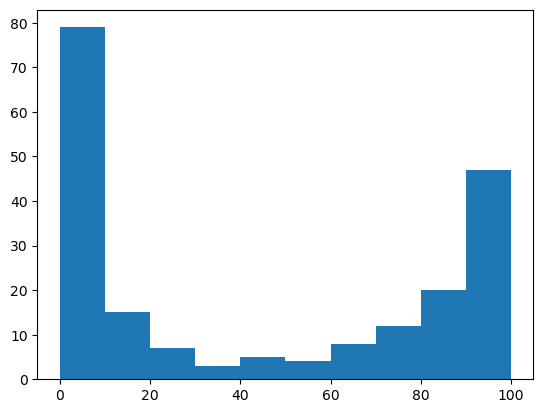

In [20]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

We can plot the probability contours: these are rather tight!

/var/folders/wq/mr3zj9r14dzgjnq9rjx_vqbc0000gn/T/ipykernel_18782/638263581.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
/var/folders/wq/mr3zj9r14dzgjnq9rjx_vqbc0000gn/T/ipykernel_18782/638263581.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)


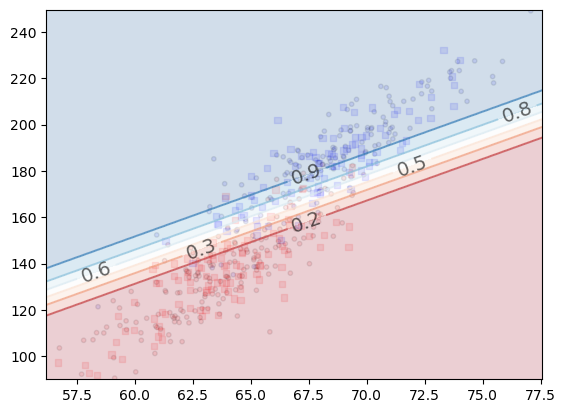

In [21]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

The score function of the estimator is used to evaluate a parameter setting. These are the sklearn.metrics.accuracy_score for classification and sklearn.metrics.r2_score for regression. For some applications, other scoring functions are better suited (for example in unbalanced classification, the accuracy score is often uninformative).

In [22]:
clflog.score(Xtest, ytest)

0.91

You can access the accuracy score directly:

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(ytrain, clflog.predict(Xtrain))

0.92

### Q3. Calculate the accuracy on the test set.

It should roughly equal the output of `clflog.score` above...why might the accuracy be less on the test set than the training set?

In [53]:
# your code here


### Callibration

Classification models give us probability scores.

We can compute probabilities of a particular classification -- the `predict_proba` and `predict_log_proba` methods  compute these probabilities.

You should always assess whether these probabilities are calibrated -- that is, whether a prediction made with a confidence of x% is correct approximately x% of the time. That is, for example, if a weather forecaster makes on multiple days in a decade a 10% chance of rain, and lets say there were 800 such days: then roughly 10% of these days we get rain: i.e. 80 days. This is what a good forecast means.

Let's make a plot to assess model calibration. Schematically, we want something like this:

![](http://i.imgur.com/ea5B6zr.png)

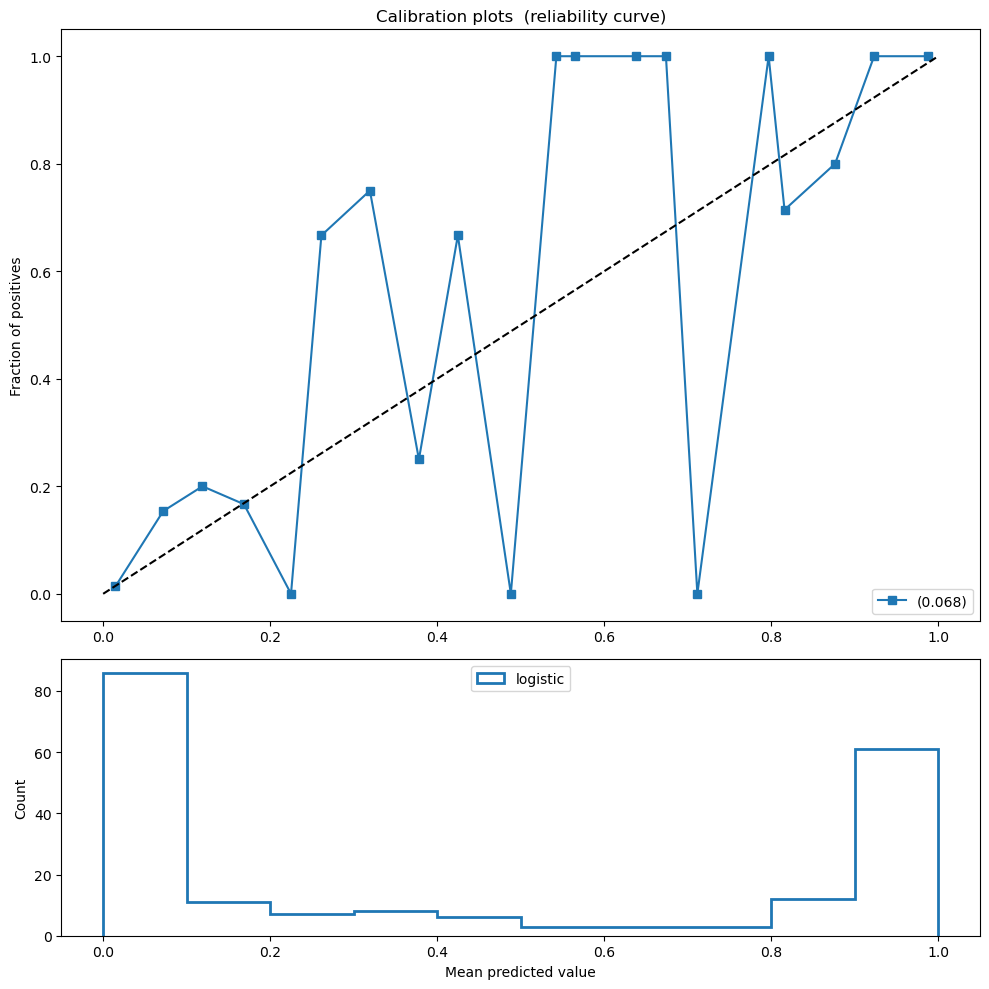

In [46]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import  calibration_curve
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
prob_pos = clflog.predict_proba(Xtest)[:, 1]
fraction_of_positives, mean_predicted_value = \
            calibration_curve(ytest, prob_pos, n_bins=20)
clf_score = brier_score_loss(ytest, prob_pos, pos_label=ytest.max())
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="(%1.3f)" % (clf_score))
ax1.plot([0,1], [0,1], "k--")
ax2.hist(prob_pos, range=(0, 1), bins=10, label="logistic",
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()


This is not bad, though it is a bit noisy about the 45 degree line which is the line of perfect callibration

## The confusion Matrix

 A classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set. There,

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix from these which lookslike this:

![hwimages](./images/confusionmatrix.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

In [24]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[99,  8],
       [10, 83]])

### Q4. What does the confusion matrix look like on the training set?

In [58]:
# your code here


Given these definitions, we typically calculate a few metrics for our classifier. First, the **True Positive Rate**:

$$TPR = Recall = \frac{TP}{OP} = \frac{TP}{TP+FN},$$

also called the Hit Rate: the fraction of observed positives (1s) the classifier gets right, or *how many true positives were recalled* or *how many of the actual positives was your model able to find*. Maximizing the recall towards 1 means keeping down the false negative rate. In a classifier try to find cancer patients, this is the number we want to maximize.

The **False Positive Rate** is defined as

$$FPR = \frac{FP}{ON} = \frac{FP}{FP+TN},$$

also called the False Alarm Rate, the fraction of observed negatives (0s) the classifier gets wrong. In general, you want this number to be low. 

Instead, you might want to maximize the
**Precision**,which tells you *how many of the predicted positive(1) hits were truly positive*

$$Precision = \frac{TP}{PP} = \frac{TP}{TP+FP}.$$

Finally the **F1** score gives us the Harmonic Score of Precision and Recall. Many analysts will try and find a classifier that maximizes this score, since it tries to minimize both false positives and false negatives simultaneously, and is thus a bit more precise in what it is trying to do than the accuracy.

$$F1 =  \frac{2*Recall*Precision}{Recall + Precision}$$


`scikit-learn` helpfully gives us a classification report with all these numbers

In [25]:
from sklearn.metrics import classification_report
print(classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       107
           1       0.91      0.89      0.90        93

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



## The cancer doctor

Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

In [47]:
def t_repredict(est,t, Xtest):
    probs=est.predict_proba(Xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

See how the false negatives get suppressed?

In [50]:
confusion_matrix(ytest, t_repredict(clflog, 0.05, Xtest))

array([[72, 37],
       [ 1, 90]])